<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Neural Network Framework (Keras)

## *Data Science Unit 4 Sprint 2 Assignmnet 3*

## Use the Keras Library to build a Multi-Layer Perceptron Model on the Boston Housing dataset

- The Boston Housing dataset comes with the Keras library so use Keras to import it into your notebook. 
- Normalize the data (all features should have roughly the same scale)
- Import the type of model and layers that you will need from Keras.
- Instantiate a model object and use `model.add()` to add layers to your model
- Since this is a regression model you will have a single output node in the final layer.
- Use activation functions that are appropriate for this task
- Compile your model
- Fit your model and report its accuracy in terms of Mean Squared Error
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Run this same data through a linear regression model. Which achieves higher accuracy?
- Do a little bit of feature engineering and see how that affects your neural network model. (you will need to change your model to accept more inputs)
- After feature engineering, which model sees a greater accuracy boost due to the new features?

### Load Dataset

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [158]:
train_data.shape

(404, 13)

In [159]:
test_data.shape

(102, 13)

### Normalize Data

In [160]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

In [175]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer='adam',
          loss='mse',
          metrics=['mse'])

In [176]:
history = model.fit(train_data, train_targets, epochs=150, batch_size=16, verbose=0)

### MSE

In [177]:
mse = model.evaluate(test_data, test_targets)[0]
mse

102/102 [==============================] - 0s 2ms/step


15.006192974015779

### Plotting loss/epoch

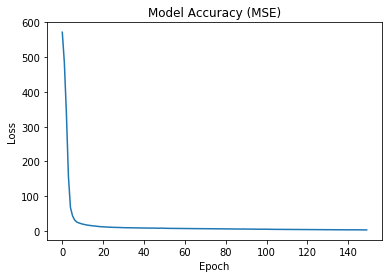

In [178]:
plt.plot(history.history['mean_squared_error'])
plt.title('Model Accuracy (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Linear Regression

In [115]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [116]:
model = LinearRegression()

In [117]:
model.fit(train_data, train_targets)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [118]:
y_pred = model.predict(test_data)
mean_squared_error(y_pred, test_targets)

23.195599256422984

we beat the linear regression model

## Use the Keras Library to build an image recognition network using the Fashion-MNIST dataset (also comes with keras)

- Load and preprocess the image data similar to how we preprocessed the MNIST data in class.
- Make sure to one-hot encode your category labels
- Make sure to have your final layer have as many nodes as the number of classes that you want to predict.
- Try different hyperparameters. What is the highest accuracy that you are able to achieve.
- Use the history object that is returned from model.fit to make graphs of the model's loss or train/validation accuracies by epoch. 
- Remember that neural networks fall prey to randomness so you may need to run your model multiple times (or use Cross Validation) in order to tell if a change to a hyperparameter is truly producing better results.

In [10]:
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [11]:
#scale values
train_images = train_images / 255.0

test_images = test_images / 255.0

In [181]:
import keras
import tensorflow as tf
model = models.Sequential()
model.add(layers.Flatten(input_shape=(28, 28)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])

In [182]:
history = model.fit(train_images, train_labels, epochs=60, verbose=0)

In [183]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)


10000/10000 [==============================] - 1s 52us/step
Test accuracy: 0.8888


### Plotting loss/epoch

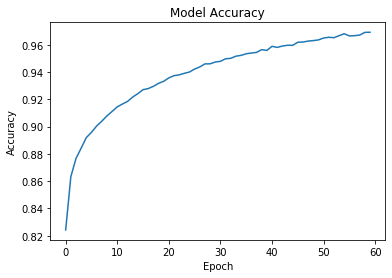

In [184]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Stretch Goals:

- Use Hyperparameter Tuning to make the accuracy of your models as high as possible. (error as low as possible)
- Use Cross Validation techniques to get more consistent results with your model.
- Use GridSearchCV to try different combinations of hyperparameters. 
- Start looking into other types of Keras layers for CNNs and RNNs maybe try and build a CNN model for fashion-MNIST to see how the results compare.